In [219]:
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.linear_model import LinearRegression

def pullsqldata():
    """This function pulls the necessary columns and rows from the PostGRES DB into a Pandas Dataframe in order 
    to continue with our EDA """
    
    engine = create_engine("postgresql:///kc_housing")
    query = """
                SELECT *
                FROM rpsale AS s
                INNER JOIN resbldg AS b ON CONCAT(s.Major,s.Minor) = CONCAT(b.Major, b.Minor)
                INNER JOIN parcel AS p ON CONCAT(s.Major,s.Minor) = CONCAT(p.Major,p.Minor)
                WHERE EXTRACT(YEAR FROM CAST(documentdate AS DATE)) = 2018
                    AND p.proptype = 'R'
                ;"""
    kc_df = pd.read_sql(sql = query, con = engine)
    return kc_df


In [220]:
df_pull = pullsqldata()


In [221]:
upper_range = 2*df_pull['saleprice'].std() + df_pull['saleprice'].mean()

df = df_pull[(df_pull['saleprice']> 10000) & (df_pull['saleprice'] < upper_range )]
# df = df[(df.nbrlivingunits == 1) | (df.nbrlivingunits == 2)]
# can't find houses for less than 20,000
df.bldggradevar.count()
# df.bldggrade.count()

28747

In [227]:
df1 = df[['saleprice','sqfttotliving']]
df1['logprice'] = np.log(df['saleprice'])
df1

/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,saleprice,sqfttotliving,logprice
0,310000.0,1200.0,12.644328
3,500000.0,4100.0,13.122363
6,456800.0,1720.0,13.032001
7,461000.0,2840.0,13.041153
8,80000.0,2980.0,11.289782
...,...,...,...
43732,579000.0,3350.0,13.269058
43735,483000.0,980.0,13.087772
43736,483000.0,740.0,13.087772
43737,315000.0,3830.0,12.660328


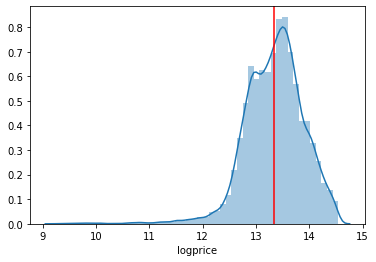

In [228]:
sns.distplot(df1['logprice'])
plt.axvline(df1['logprice'].mean(), color = 'red');

In [229]:
for name in df1.columns:
    print(name)

saleprice
sqfttotliving
logprice


In [230]:
Y1 = df1['logprice']
X1 = df1['sqfttotliving']


model1 = sm.OLS(Y1, X1).fit()
predictions1 = model1.predict(X1) # make the predictions by the model

# Print out the statistics
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               logprice   R-squared (uncentered):                   0.858
Model:                            OLS   Adj. R-squared (uncentered):              0.858
Method:                 Least Squares   F-statistic:                          1.739e+05
Date:                Tue, 03 Dec 2019   Prob (F-statistic):                        0.00
Time:                        16:34:00   Log-Likelihood:                         -87230.
No. Observations:               28747   AIC:                                  1.745e+05
Df Residuals:                   28746   BIC:                                  1.745e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sqfttotliving     0.0054    1.3e-05    417.042      0.000       0.005       0.005
==============================================================================
Omnibus:                     8036.864   Durbin-Watson:                   0.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            47422.961
Skew:                          -1.215   Prob(JB):                         0.00
Kurtosis:                       8.804   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [244]:
slope = float(model1.params)

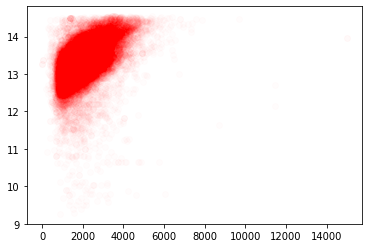

In [239]:
plt.plot(df1['sqfttotliving'], df1['logprice'], 'ro', alpha = .01)

In [248]:

x_mean = df1['sqfttotliving'].mean()
y_mean = df1['logprice'].mean()

b = y_mean - x_mean*slope
print(x_mean, y_mean, b, slope)

2098.708073885971 13.345218114393592 1.968147482080239 0.005420987689463429


In [275]:
x_line = np.linspace(0, 6000, 10000)
y_line = x_line*slope/10 + 12.2

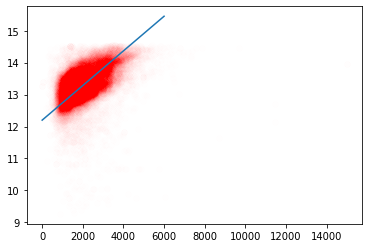

In [276]:
plt.plot(df1['sqfttotliving'],df1['logprice'], 'ro', alpha = .005)
plt.plot(x_line,y_line)

# 3D MODEL

/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


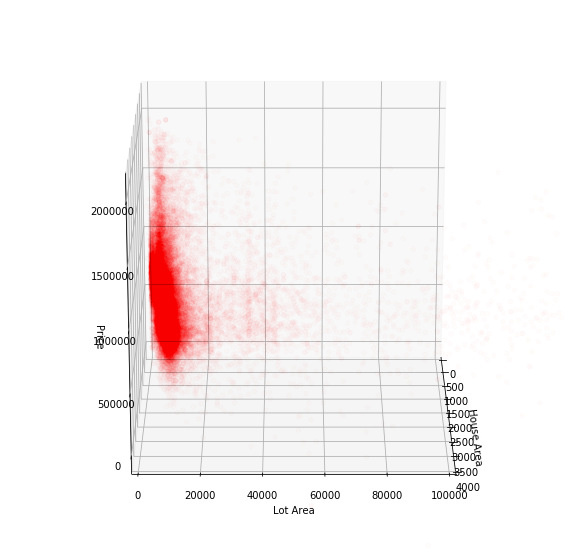

In [157]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

x = df['sqft1stfloor']+ df['sqftgarageattached']
y = df['sqftlot']
z = df['saleprice']

ax.set_xlim(0, 4000)
ax.set_ylim(0, 100000)

ax.scatter(x, y, z, c='r', marker='o', alpha = .01)

ax.set_xlabel('House Area')
ax.set_ylabel('Lot Area')
ax.set_zlabel('Price')

ax.view_init(20, 0)
plt.draw()

    

In [158]:

df['foot'] = df['sqft1stfloor']+ df['sqftgarageattached']

x = df[['foot', 'sqftlot']]
z = df['saleprice']


/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [153]:
mlr= LinearRegression()

In [167]:

model2 = sm.OLS(z, x).fit()
predictions2 = model2.predict(x) # make the predictions by the model

# Print out the statistics
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              saleprice   R-squared (uncentered):                   0.748
Model:                            OLS   Adj. R-squared (uncentered):              0.748
Method:                 Least Squares   F-statistic:                          4.271e+04
Date:                Tue, 03 Dec 2019   Prob (F-statistic):                        0.00
Time:                        14:07:24   Log-Likelihood:                     -4.1187e+05
No. Observations:               28747   AIC:                                  8.237e+05
Df Residuals:                   28745   BIC:                                  8.238e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
foot         428.6213      1.547    277.070      0.000     425.589     431.653
sqftlot       -0.2170      0.042     -5.142      0.000      -0.300      -0.134
==============================================================================
Omnibus:                     2192.537   Durbin-Watson:                   0.768
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8941.497
Skew:                           0.288   Prob(JB):                         0.00
Kurtosis:                       5.671   Cond. No.                         38.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [175]:
x_bar = df.foot.mean()
y_bar = df.sqftlot.mean()
z_bar = df.saleprice.mean()
coef = model2.params
a = float(coef[0])
b = float(coef[1])

In [176]:
d = -z_bar - a*x_bar - b*y_bar

In [177]:
d

-1355669.491683922